# DVM with and without TEFSC 

### This study compares lift coefficient predicted by DVM with and without TEFSC. Studies are performed for a NACA0015 aerofoil undergoing prescribed sinusoidal motion in pitch and plunge.

###### Test case from Liu, Z., Lai, J., Young, J., Tian, F-B., 2017, Discrete Vortex Method with Flow Separation Corrections for Flapping-Foil Power Generators. AIAA Journal, Vol. 55, No.2.

In [1]:
#Include the UNSflow libraries
#Pkg.clone("git://github.com/KiranUofG/UNSflow")
include("../src/UNSflow.jl")
using UNSflow

### Case details:
### 2D flat plate in a uniform velocity field undergoing prescribed pitch and plunge motions:
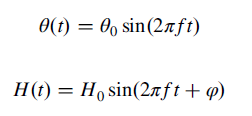

### Kinematics definition:

In [2]:
fstar = 0.18 #nondimensional flapping frequency fstar = fc/U
theta0 = 60. #pitch amplitude in deg

#Sinusoidal pitch:
    #mean = 0
    #amplitude = theta0 
    #k = fstar
    #phi = 0 deg
    
alphadef = SinDef(0.,theta0*pi/180,fstar*pi,0.)

#Sinusoidal plunge:
    #mean = 0
    #amplitude = theta0
    #k = fstar
    #phi = 90 deg
    
hdef = SinDef(0.,theta0*pi/180,fstar*pi,90*pi/180)

#Freestream velocity is a constant. Set as constant = 1
udef = ConstDef(1.)

#The full kinematics are collected as:
full_kinem = KinemDef(alphadef, hdef, udef)

UNSflow.KinemDef(UNSflow.SinDef(0.0,1.0471975511965976,0.5654866776461628,0.0),UNSflow.SinDef(0.0,1.0471975511965976,0.5654866776461628,1.5707963267948966),UNSflow.ConstDef(1.0))

### Define the surface undergoing motion and the flowfield. The LESP_crit used below is the critical LESP parameter which is used to predict and modulate LEV shedding - it depends on the airfooil shape and Reynolds number of operation. See paper for more details.

In [3]:
pvt = 0.333 

lespcrit = [0.19;] #LEV shedding turned off 
#Not sure if it is supposed to be turned off? For this motion (for the airfoil, not flat plate) no LEVs have been observed

surf = TwoDSurf("naca0015.dat", pvt, full_kinem,lespcrit)

curfield = TwoDFlowField()

UNSflow.TwoDFlowField(UNSflow.ConstDef(0.0),UNSflow.ConstDef(0.0),[0.0],[0.0],UNSflow.TwoDVort[],UNSflow.TwoDVort[],UNSflow.TwoDVort[])

### Specify simulation details and run code. 

In [4]:
#Specify simulation details - time step, and number of steps.
#The default nondimensional timestep is 0.015. There is usually no need to change this. 
ncyc = 3 #Number of cycles to be simulated
time_total = 1/fstar*ncyc #Required total time
nsteps = Int(round(time_total/0.015))

1111

In [5]:
#Now the code is run as :
#The variables mat, surf and curfield are returned
@time mat, surf, curfield = ldvm(surf, curfield, nsteps);

403.541554 seconds (7.24 M allocations: 802.311 MB, 0.23% gc time)


In [6]:
sepdef = SeparationParams(15.25,3.0,2.3,"Original")

UNSflow.SeparationParams(15.25,3.0,2.3,"Original","Effective",0.0,-0.135,0.04,2.0,"Dymore","piecewise",3.0,0.12,-1.0,false)

In [7]:
#Now the code is run as :
#The variables mat, surf and curfield are returned
@time mat_klb, surf_klb, curfield_klb = ldvm_klb_tr(surf, curfield, sepdef, nsteps);

1617.478359 seconds (7.01 M allocations: 1.424 GB, 0.12% gc time)


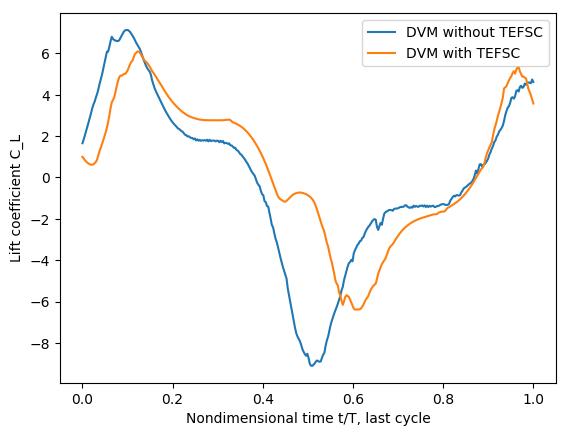

PyObject <matplotlib.legend.Legend object at 0x000000001CBCEDD8>

In [9]:
range_full = round(Int,(ncyc-1)*nsteps/ncyc)+1:nsteps
tbyT=linspace(0,1,length(range_full))

plot(tbyT,mat[range_full,6], label="DVM without TEFSC")
plot(tbyT,mat_klb[range_full,6], label="DVM with TEFSC")
xlabel("Nondimensional time t/T, last cycle")
ylabel("Lift coefficient C_L")
legend()

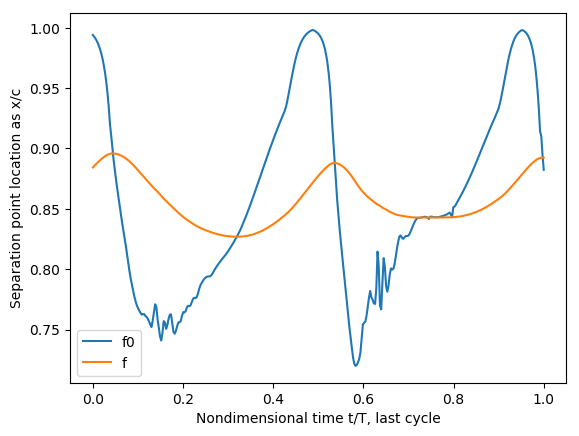

PyObject <matplotlib.legend.Legend object at 0x000000001D452B38>

In [13]:
#plot(tbyT,mat_klb[range_full,5]*180/pi)
plot(tbyT,mat_klb[range_full,9],label="f0")
plot(tbyT,mat_klb[range_full,10],label="f")
xlabel("Nondimensional time t/T, last cycle")
ylabel("Separation point location as x/c")
legend()

### Question: what would be the best method of assessing the results after reaching convergence?

### Convergence study

In [10]:
#Create range for the last cycle
range=collect(round(Int,(ncyc-1)*nsteps/ncyc)+1:nsteps)
prev_temp = range[1]

#Create ranges for every other cycle
for i = 2:ncyc
    ran=collect(round(Int,(ncyc-i)*nsteps/ncyc)+1:prev_temp)
        if(length(ran)>length(range[i-1]))
            while(!(length(ran)==size(range,1)))
                pop!(ran)
            end
        else
            while(!(length(ran)==size(range,1)))
                pop!(range)
            end
        end
    range=hcat(range,ran)
    prev_temp=ran[1]
end

#Ranges are stored in an array of Int64s, 
#first column represents last cycle,
#second column represents the cycle before last, etc.

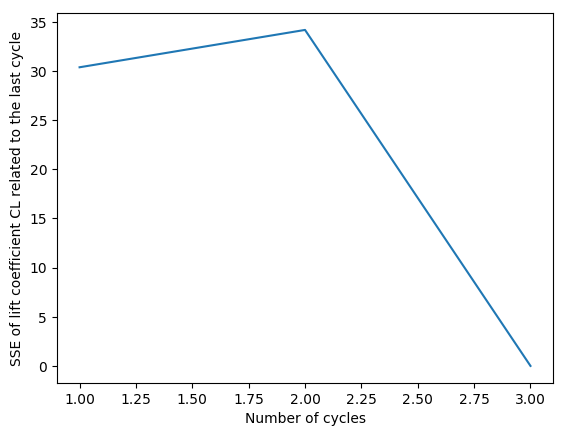

PyObject <matplotlib.text.Text object at 0x000000001CC6BA90>

In [11]:
#Calculate SSE of lift coefficient related to the last cycle
SSE=zeros(size(range,2))

for i = 1:size(range,2)
    for n = 1:size(range,1)
        SSE[i]=SSE[i]+(mat_klb[range[n,i],6]-mat_klb[range[n,1],6])^2
    end
    SSE[i]=SSE[i]/sqrt(size(range,1))
end

plot(1:ncyc,flipdim(SSE,1))
xlabel("Number of cycles")
ylabel("SSE of lift coefficient CL related to the last cycle")

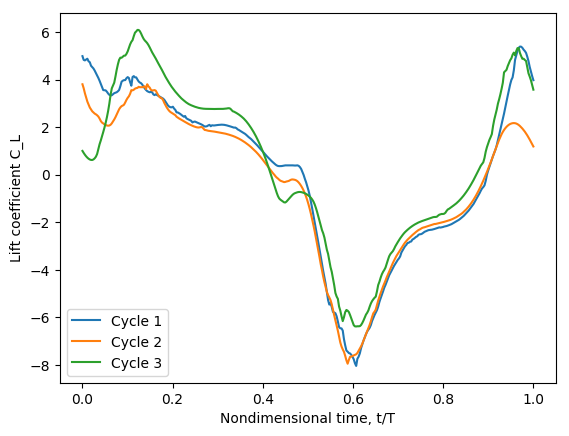

PyObject <matplotlib.legend.Legend object at 0x00000000293D1748>

In [15]:
for i = 1:ncyc
    plot(tbyT,mat_klb[range[:,ncyc-i+1],6], label="Cycle $i")
end
xlabel("Nondimensional time, t/T")
ylabel("Lift coefficient C_L")
legend()

The solution is not converged yet, more cycles are needed. Unfortunately, it takes very long to compute (I'm curious where from come the differences between computation time of ldvm and ldvm_klb_tr solvers).

Also, the results are nowhere close to the one publish in Liu's paper (see below).

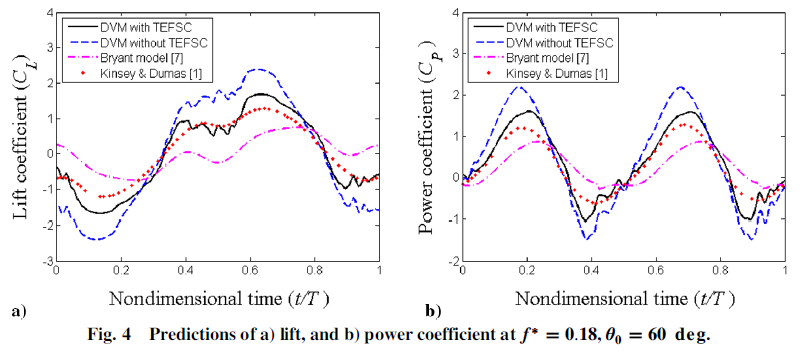